RNN with pytorch
================



## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/bin/python

## Imports



In [1]:
import sys
sys.path.insert(0, '../')

import torch
import gc
import pandas as pd
from time import perf_counter

from src.network import Network
from src.plot_utils import plot_con
from src.decode import decode_bump
from src.utils import clear_cache

## Helpers



In [1]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

## Documentation



Neurotorch is an implementation of a rate based recurrent neural network trainer and simulator.



### Simulation



#### Dynamics



##### Currents



Neuron $i$ in population $A$ has a reccurent input $h^A_i$,

or not



##### Rates



The models can have rate dynamics (setting **RATE<sub>DYN</sub>** to 1 in the configuration file):

Here, $r_i$ is the rate of unit $i$ in population $A$

otherwise rates will be instantaneous:

Here $\Phi$ is the transfer function defined in **src/activation.py**



#### Connectivity



Probability of connection from population B to A:



##### Sparse Nets



by default it is a sparse net

otherwise
it can be cosine

and also low rank



##### All to all



where Pij can be as above.



## RNN with torch



### Parameters



In [1]:
REPO_ROOT = "/home/leon/models/NeuroTorch"

### Single Trial



Here we will run a single simulation with the parameters provided in config<sub>2pop.yml</sub>



In [1]:
start = perf_counter()

# First we create a network with
model = Network('config_2pop.yml', '', REPO_ROOT)

# then we run the simulation with
output = model()

print('output', output.shape)
# model outputs a tensor of rates of size (N_BATCH, N_STEPS, N_NEURON), so we need to convert it to numpy

rates = output[0].cpu().numpy()
print('rates', rates.shape)

end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

Ne = model.Na[0].detach().cpu().numpy()
N = model.N_NEURON

output torch.Size([1, 101, 8000])
rates (101, 8000)
Elapsed (with compilation) = 0h 0m 5s

In [1]:
print(torch.cuda.memory_allocated()/100000)
del model
clear_cache()
print(torch.cuda.memory_allocated()/100000)

4125.568
117.51936

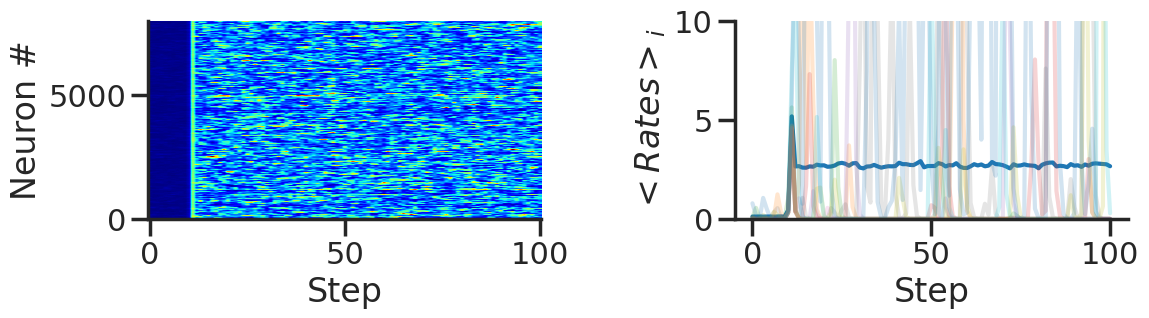

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

r_max = 10

ax[0].imshow(rates.T, aspect='auto', cmap='jet', vmin=0, vmax=r_max, origin='lower')
ax[0].set_ylabel('Neuron #')
ax[0].set_xlabel('Step')

ax[1].plot(rates.mean(-1))
for i in range(10):
    ax[1].plot(rates[..., i], alpha=0.2)

ax[1].set_ylabel('$<Rates>_i$')
ax[1].set_xlabel('Step')
ax[1].set_ylim([0, r_max])
plt.show()

### Multiple Trials



#### Multiple initial conditions



We can run multiple initializations of the network changing N<sub>BATCH</sub> to the number of initializations that we want.



In [1]:
model = Network('config_2pop.yml', '', REPO_ROOT)

model.N_BATCH = 10
rates = model().cpu().numpy()
print('rates', rates.shape)

rates (10, 101, 8000)

#### Batching feedforward inputs



To run some parameter searches, we can easily batch over a different set of ff inputs
Let's see an example where we change the ff inputs to the excitatory population



##### The easy way (but memory consuming)



We create a batch of inputs of size (N<sub>BATCH</sub>, N<sub>STEPS</sub>, N<sub>NEURON</sub>)



In [1]:
model = Network('config_2pop.yml', '', REPO_ROOT)

ff_inputs = []
for i in range(10):
    model.Ja0[:, 0, :] = i  # here we set the ff input to E to value i in 0 .. 10
    ff_inputs.append(model.init_ff_input())

ff_inputs = torch.vstack(ff_inputs)
print('ff_inputs', ff_inputs.shape)

ff_inputs torch.Size([10, 4440, 10000])

Then we path these inputs to the model



In [1]:
rates = model(ff_inputs).cpu().numpy()
print(rates.shape)

(10, 101, 8000)

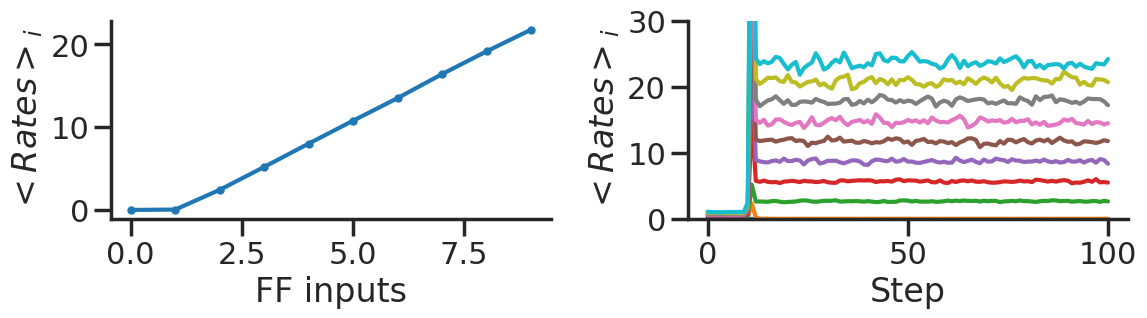

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(rates.mean((1,-1)), '-o')
ax[0].set_ylabel('$<Rates>_i$')
ax[0].set_xlabel('FF inputs')

ax[1].plot(rates.mean(-1).T)  
ax[1].set_ylabel('$<Rates>_i$')
ax[1].set_xlabel('Step')
ax[1].set_ylim([0, 30])
plt.show()

##### The hard way (slow but more memory friendly)



We create a batch of ff inputs that are updated at each time step



In [1]:
model = Network('config_2pop.yml', '', REPO_ROOT)

N_BATCH = 10
print('original ff_input', model.Ja0.shape)

new_Ja0 = model.Ja0.repeat((N_BATCH, 1, 1))

print('new ff_input', new_Ja0.shape)

new_Ja0[:, 0, :] = torch.linspace(0, 10, 10, device='cuda').unsqueeze(-1) * model.M0 * torch.sqrt(model.Ka[0])

print('batched ff_input', new_Ja0[:, 0].squeeze(-1))

original ff_input torch.Size([1, 2, 1])
new ff_input torch.Size([10, 2, 1])
batched ff_input tensor([   0.0000,  124.2260,  248.4520,  372.6780,  496.9040,  621.1299,
         745.3560,  869.5820,  993.8080, 1118.0339], device='cuda:0')

In [1]:
model.N_BATCH = N_BATCH
model.Ja0 = new_Ja0
model.LIVE_FF_UPDATE = 1

rates = model().cpu().numpy()
print('rates', rates.shape)

rates (10, 101, 8000)

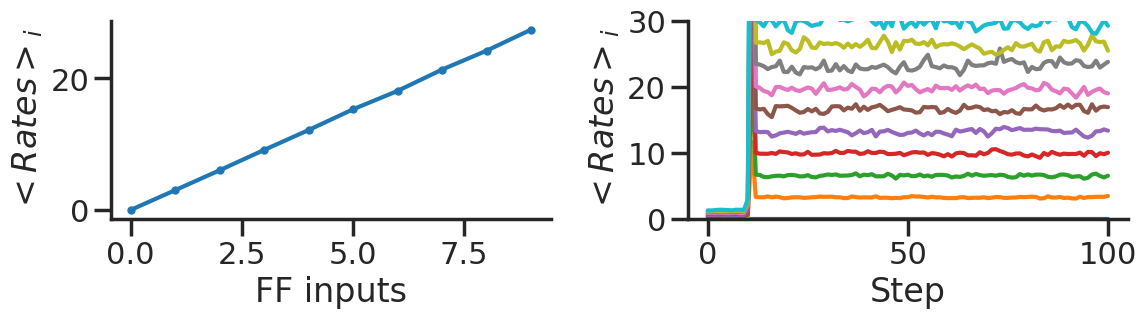

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(rates.mean((1,-1)), '-o')
ax[0].set_ylabel('$<Rates>_i$')
ax[0].set_xlabel('FF inputs')

ax[1].plot(rates.mean(-1).T)  
ax[1].set_ylabel('$<Rates>_i$')
ax[1].set_xlabel('Step')
ax[1].set_ylim([0, 30])
plt.show()